# Use pretrained network to extract feature
### pretrained network https://github.com/geifmany/cifar-vgg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

from keras.datasets import cifar100
# from keras.applications.densenet import DenseNet121
# from keras.appliactions.vgg16 import VGG16
from keras.models import load_model
from keras.layers import Input, Flatten, Dense
from keras.models import Model

from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


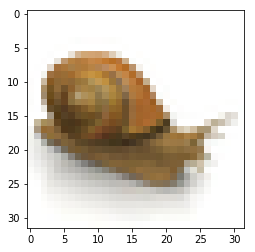

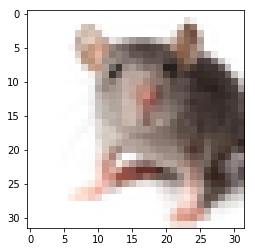

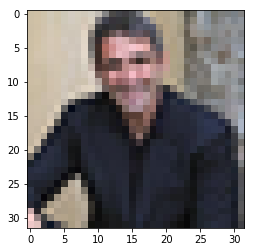

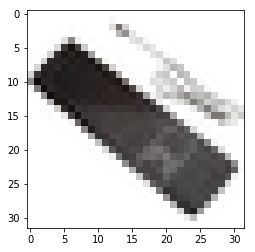

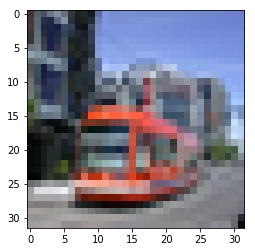

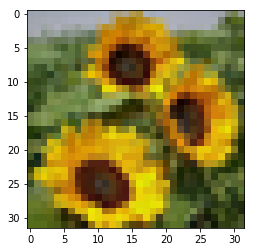

Images shape (6, 32, 32, 3)


In [2]:
def read_img(file_names):
    img_arrs = []
    for file_name in file_names:
        img = Image.open(file_name).convert('RGB')
        img = img.resize((32, 32), Image.ANTIALIAS)
        plt.imshow(img)
        plt.show()
        img_arrs.append(np.asarray(img, dtype = 'uint8'))
    return img_arrs

# 'cloud.png', 'butterfly.png', 'crab.gif', 'keyboard.png', 'snake.jpeg', 'caterpillar.jpg', 'elephant.jpeg', 'seal.jpg', 'lobster.jpg', 'orange.png', 'raccoon.jpg'
file_names = ['snail.jpg', 'mouse.jpg', 'man.jpg', 'computer_keyboard.jpg', 'streetcar.jpeg', 'sunflowers.jpg']

img_arrs = np.array(read_img(file_names)) / 255.

print('Images shape', img_arrs.shape)

X_train original shape (50000, 32, 32, 3)
y_train original shape (50000,)
X_test original shape (10000, 32, 32, 3)
y_test original shape (10000,)


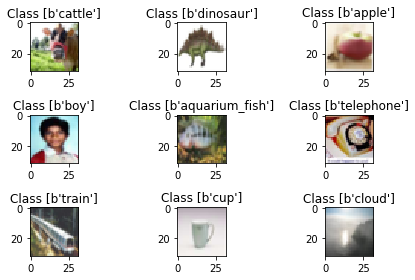

In [3]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class_names = unpickle('meta')
class_names = np.array(class_names[b'fine_label_names'])

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], interpolation = 'none')
    plt.title("Class {}".format(class_names[y_train[i]]))
plt.tight_layout()

# normalization
X_train = X_train / 255.
X_test = X_test / 255.

y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
    
# split train and validation
# sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.5, random_state = 0)
# for train_idx, val_idx in sss.split(X_train, y_train):
#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

print("X_train original shape {}".format(X_train.shape))
print("y_train original shape {}".format(y_train.shape))
# print("X_val original shape {}".format(X_val.shape))
# print("y_val original shape {}".format(y_val.shape))
print("X_test original shape {}".format(X_test.shape))
print("y_test original shape {}".format(y_test.shape))

# Pretrained network

In [4]:
# model = DenseNet121(include_top = False, weights = 'imagenet')
# model = VGG16(include_top = False, weights = 'imagenet')
model = load_model('cifar100vgg_model.h5')
model.summary()

print('Get flatten layer...')

input = model.input
output = model.get_layer('flatten_1').output
model = Model(input = input, output = output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
__________

/usr/local/lib/python3.5/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("co...)`
  # Remove the CWD from sys.path while we load stuff.


In [5]:
X_train_feature, X_test_feature = model.predict(X_train), model.predict(X_test)
img_feature = model.predict(img_arrs)

print('X_train_feature shape {}'.format(X_train_feature.shape))
print('X_test feature shape {}'.format(X_test_feature.shape))

X_train_feature shape (50000, 512)
X_test feature shape (10000, 512)


# Nearest neighbour

In [6]:
# nn_clf = NearestCentroid()
# nn_clf.fit(X_train_feature, y_train.ravel())
# mean_accuracy = nn_clf.score(X_test_feature, y_test.ravel())
# print('Mean accuracy', mean_accuracy)
# prediction_result = nn_clf.predict(img_feature)
# class_names[prediction_result]

In [7]:
combined_feature = np.concatenate((X_train_feature, img_feature), axis = 0)
nn = NearestNeighbors(n_neighbors = 11, algorithm = 'ball_tree').fit(combined_feature)
distances, indices = nn.kneighbors(img_feature)

for i in range(img_feature.shape[0]):
    indice = indices[i]
    indice = indice[indice < 50000]
    print(file_names[i])
    
    neighbors = y_train[indice]
    most_freq = np.bincount(neighbors).argmax()
    print('\tMost neighbors: ', class_names[most_freq], most_freq)

snail.jpg
	Most neighbors:  b'snail' 77
mouse.jpg
	Most neighbors:  b'mouse' 50
man.jpg
	Most neighbors:  b'man' 46
computer_keyboard.jpg
	Most neighbors:  b'keyboard' 39
streetcar.jpeg
	Most neighbors:  b'streetcar' 81
sunflowers.jpg
	Most neighbors:  b'sunflower' 82


# Dimension reduction

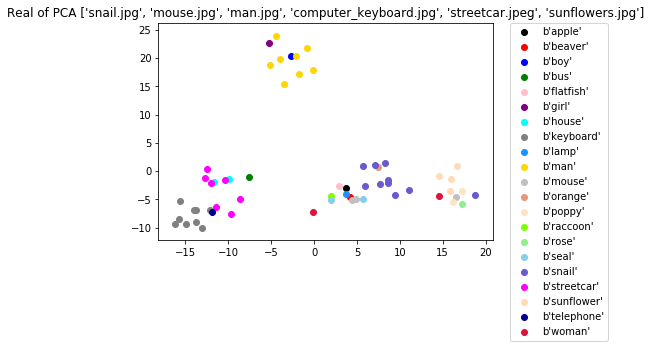

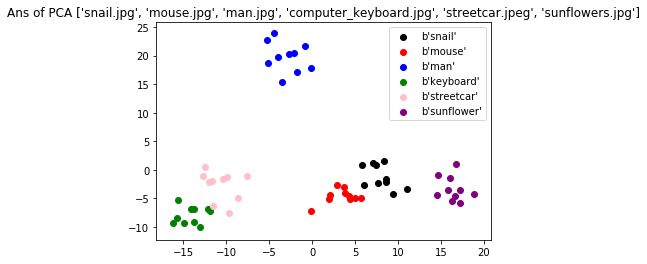

In [8]:
flatten_indices = np.concatenate(indices)
flatten_indices = flatten_indices[flatten_indices < 50000]
selected_feature = X_train_feature[flatten_indices]
selected_label = y_train[flatten_indices]
unique_label = np.unique(selected_label)
unique_class_name = [class_names[idx] for idx in unique_label]

ans_label = [77, 50, 46, 39, 81, 82]
ans_class_name = [class_names[idx] for idx in ans_label]
# plot the results from nearest neighbor
def plot_pca():
    pca = PCA(n_components = 2)
    X_train_new = pca.fit_transform(selected_feature)
    # lda = LinearDiscriminantAnalysis(n_components = 2)
    # X_train_new = lda.fit(X_train_feature, y_train).transform(X_train_feature)

    colors = ['black', 'red', 'blue', 'green', 'pink', 'purple', 'cyan', 'grey', 'dodgerblue', 'gold', 
              'silver', 'darksalmon', 'bisque', 'chartreuse', 'lightgreen', 'skyblue', 'slateblue', 'magenta', 'peachpuff', 'darkblue', 
              'crimson']

    for color, i, class_name in zip(colors, unique_label, unique_class_name):
        plt.scatter(X_train_new[selected_label == i, 0], X_train_new[selected_label == i, 1], color = color, label = class_name)
    
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., shadow = False, scatterpoints = 1)
    plt.title('Real of PCA {}'.format(file_names))
    plt.show()
    
    idx = 0
    for color, i, class_name in zip(colors, ans_label, ans_class_name):
        plt.scatter(X_train_new[idx * 10 : (idx + 1) * 10, 0], X_train_new[idx * 10 : (idx + 1) * 10, 1], color = color, label = class_name)
        idx += 1
    
    plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
    plt.title('Ans of PCA {}'.format(file_names))
    plt.show()

plot_pca()
    
# for i in range(100):
#     plot_pca([i])

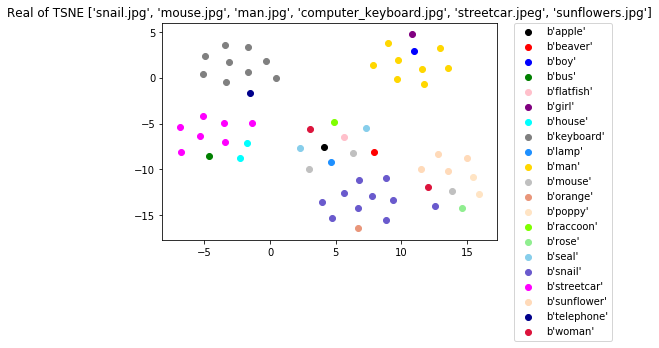

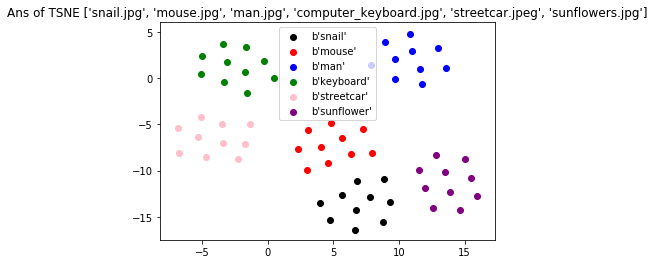

In [9]:
def plot_tsne():
    tsne = TSNE(n_components = 2)
    X_train_new = tsne.fit_transform(selected_feature)
    # lda = LinearDiscriminantAnalysis(n_components = 2)
    # X_train_new = lda.fit(X_train_feature, y_train).transform(X_train_feature)

    colors = ['black', 'red', 'blue', 'green', 'pink', 'purple', 'cyan', 'grey', 'dodgerblue', 'gold', 
              'silver', 'darksalmon', 'bisque', 'chartreuse', 'lightgreen', 'skyblue', 'slateblue', 'magenta', 'peachpuff', 'darkblue', 
              'crimson']

    for color, i, class_name in zip(colors, unique_label, unique_class_name):
        plt.scatter(X_train_new[selected_label == i, 0], X_train_new[selected_label == i, 1], color = color, label = class_name)
    
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., shadow = False, scatterpoints = 1)
    plt.title('Real of TSNE {}'.format(file_names))
    plt.show()
    
    idx = 0
    for color, i, class_name in zip(colors, ans_label, ans_class_name):
        plt.scatter(X_train_new[idx * 10 : (idx + 1) * 10, 0], X_train_new[idx * 10 : (idx + 1) * 10, 1], color = color, label = class_name)
        idx += 1
    
    plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
    plt.title('Ans of TSNE {}'.format(file_names))
    plt.show()

plot_tsne()